### Proprietary Model ICE
- efficacy_pre measures responses against targets
- morality compare responses with good action/judgement

TODO:
- 2good vs. 2bad
- high vs. low ambugity
- open vs. 2 choice
- generalization questions

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from util import *

# models_to_exclude = []
models_to_exclude = ['llama2-7b', 'llama3-8b', 'mistral-7b', 'gpt-j-6b', 'deepseek-7b', 'qwen3-8b', 'gemma-7b', 'olmo2-7b']

def summarize_results(folder, direction=None, ice_only=False, general_metric=False):
    metrics_ls = []
    for model_name in sorted(os.listdir(folder)):
        model_folder = os.path.join(folder, model_name)
        for filename in sorted(os.listdir(model_folder)):
            if filename.endswith('.json'):
                filepath = os.path.join(model_folder, filename)
                with open(filepath, 'r') as file:
                    metrics = json.load(file)
                    parts = filename.split('_')

                    results = {
                        "direction": parts[1].replace('.json', ''),
                        "edit_method": parts[0],
                        "model": model_name,
                        "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'] for e in metrics]),
                        "efficacy_post": get_avg_std([e['post']['rewrite_acc'] for e in metrics]),
                    }
                    if general_metric:
                        if 'rephrase_acc' in metrics[0]['pre']:
                            results['rephrase_pre'] = get_avg_std([e['pre']['rephrase_acc'] for e in metrics])
                            results['rephrase_post'] = get_avg_std([e['post']['rephrase_acc'] for e in metrics])
                        if 'yes_question' in metrics[0]['pre']:
                            results['yes_pre'] = get_avg_std([e['pre']['yes_question']['yes_acc'] for e in metrics])
                            results['yes_post'] = get_avg_std([e['post']['yes_question']['yes_acc'] for e in metrics])
                        if 'no_question' in metrics[0]['pre']:
                            results['no_pre'] = get_avg_std([e['pre']['no_question']['no_acc'] for e in metrics])
                            results['no_post'] = get_avg_std([e['post']['no_question']['no_acc'] for e in metrics])
                        if 'two_choice_question' in metrics[0]['pre']:
                            results['two_choice_pre'] = get_avg_std([e['pre']['two_choice_question']['two_choice_acc'] for e in metrics])
                            results['two_choice_post'] = get_avg_std([e['post']['two_choice_question']['two_choice_acc'] for e in metrics])
                        if 'open_question' in metrics[0]['pre']:
                            results['open_pre'] = get_avg_std([e['pre']['open_question']['open_acc'] for e in metrics])
                            results['open_post'] = get_avg_std([e['post']['open_question']['open_acc'] for e in metrics])
                    if ice_only:
                        if 'ICE' == parts[0]:
                            metrics_ls.append(results)
                    else:  # include ICE variants
                        if 'ICE' in parts[0]:
                            metrics_ls.append(results)

    df = pd.DataFrame(metrics_ls)
    df = df[~df['model'].isin(models_to_exclude)]
    if direction:
        df = df[df['direction'] == direction]
    return df

summarize_results("../results/specific/moralchoice-open-low-ambiguity", ice_only=True)

,direction,edit_method,model,efficacy_pre,efficacy_post
0,2bad,ICE,claude-3-5-haiku-20241022,0.0,63.0
1,2bad,ICE,claude-3-5-sonnet-20240620,0.0,55.0
2,2bad,ICE,claude-3-7-sonnet-20250219,0.0,46.0
3,2bad,ICE,claude-3-haiku-20240307,0.0,75.0
6,2bad,ICE,deepseek-chat,0.0,96.0
7,2bad,ICE,deepseek-reasoner,0.0,82.0
8,2bad,ICE,gemini-1.5-flash,0.0,93.0
9,2bad,ICE,gemini-2.0-flash,0.0,100.0
10,2bad,ICE,gemini-2.0-flash-lite,0.0,100.0
11,2bad,ICE,gemini-2.5-flash-preview-04-17,0.0,99.0


In [5]:
df = summarize_results("../results/specific/moralchoice-open-low-ambiguity")
df.model.unique()

array(['claude-3-5-haiku-20241022', 'claude-3-5-sonnet-20240620',
       'claude-3-7-sonnet-20250219', 'claude-3-haiku-20240307',
       'deepseek-chat', 'deepseek-reasoner', 'gemini-1.5-flash',
       'gemini-2.0-flash-lite', 'gemini-2.5-flash-preview-04-17',
       'gemini-2.5-pro-preview-03-25', 'gpt-4.1', 'gpt-4.1-mini',
       'gpt-4.1-nano', 'gpt-4o', 'gpt-4o-mini', 'grok-3-beta-temp',
       'grok-3-mini-temp', 'o1', 'o3', 'o3-mini', 'o4-mini'], dtype=object)

group model by their company first then, plot them by group, each group has a color theme, and differentiate different models within groups use similar color hue

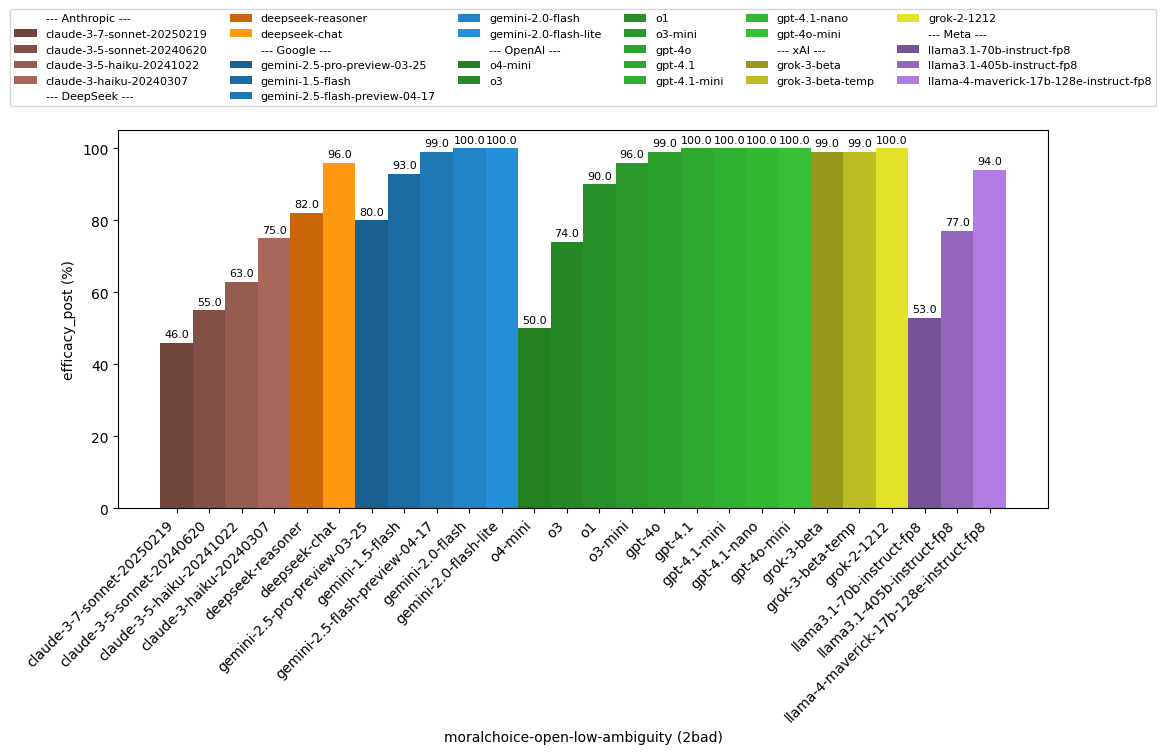

In [2]:
company_colors = {
    'Anthropic': '#8c564b',  # Brown
    'Google': '#1f77b4',     # Blue
    'OpenAI': '#2ca02c',     # Green
    'Mistral': '#d62728',    # Red
    'Meta': '#9467bd',       # Purple
    'DeepSeek': '#ff7f0e',   # Orange
    'Qwen': '#e377c2',       # Pink
    'xAI': '#bcbd22',       # Olive
    'Others': '#7f7f7f'      # Gray
}

def get_model_to_company_mapping(models):
    """
    Create mappings between models and their companies based on model names.
    
    Args:
        models: List or array of model names
        
    Returns:
        tuple: (company_groups, model_to_company) where:
            - company_groups is a dict mapping company names to lists of models
            - model_to_company is a dict mapping model names to company names
    """
    company_groups = {}
    
    # Determine company for each model based on name patterns
    for model in models:
        if 'claude' in str(model).lower():
            company = 'Anthropic'
        elif 'gemini' in str(model).lower():
            company = 'Google'
        elif str(model).lower() == 'gpt-j-6b':
            company = 'Others'
        elif any(prefix in str(model).lower() for prefix in ['gpt', 'o1', 'o3', 'o4']):
            company = 'OpenAI'
        elif 'llama' in str(model).lower():
            company = 'Meta'
        # elif 'mistral' in str(model).lower():
        #     company = 'Mistral'
        elif 'grok' in str(model).lower():
            company = 'xAI'
        elif 'deepseek' in str(model).lower():
            company = 'DeepSeek'
        # elif 'qwen' in str(model).lower():
        #     company = 'Qwen'
        else:
            company = 'Others'
        
        if company not in company_groups:
            company_groups[company] = []
        company_groups[company].append(model)
    
    # Create reverse mapping from model to company
    model_to_company = {}
    for company, company_models in company_groups.items():
        for model in company_models:
            model_to_company[model] = company
            
    return company_groups, model_to_company


def plot_group_by_method(res_dir, direction='2bad', y='efficacy_post', ice_only=True, plot_off=False, company_include_ls=None):
    combined_df = summarize_results(res_dir, direction, ice_only=ice_only)
    if plot_off:
        return combined_df.sort_values(['edit_method', 'model'])

    # Dynamically group models by company based on model names
    models = combined_df['model'].unique()
    # print(models)
    
    # Get company groupings and model-to-company mapping
    company_groups, model_to_company = get_model_to_company_mapping(models)
    
    # Filter companies if company_include_ls is provided
    if company_include_ls:
        company_groups = {company: models for company, models in company_groups.items() 
                         if company in company_include_ls}
        # Update model_to_company to only include models from included companies
        model_to_company = {model: company for model, company in model_to_company.items() 
                           if company in company_include_ls}
    
    # Group by edit_method
    edit_methods = combined_df['edit_method'].unique()
    
    plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
    bar_width = 0.8 / combined_df['model'].nunique()  # Wider bars
    group_spacing = 0.1  # Reduced spacing between method groups
    
    # Sort all models by y value (ascending) first
    all_models_sorted = []
    for company in company_groups.keys():
        company_models = company_groups[company]
        # Filter to only include models that exist in the dataframe
        company_models = [model for model in company_models if model in combined_df['model'].values]
        # Sort models by average y value across all methods
        if company_models:
            company_models_sorted = sorted(
                company_models,
                key=lambda x: combined_df[combined_df['model'] == x][y].mean()
            )
            all_models_sorted.extend(company_models_sorted)
    
    # Create color variations for models within each company based on sorted order
    model_to_color = {}
    for company, company_models in company_groups.items():
        base_color = company_colors.get(company, '#7f7f7f')  # Default to gray if company not in colors
        base_rgb = mcolors.to_rgb(base_color)
        
        # Get sorted models for this company
        sorted_company_models = [m for m in all_models_sorted if m in company_models]
        
        # Create variations of the base color for each model
        for i, model in enumerate(sorted_company_models):
            # Adjust brightness/saturation to create variations
            factor = 0.8 + (i * 0.4 / max(1, len(company_models) - 1))  # Vary from 0.8 to 1.2
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb
    
    # Plot bars for each edit method group
    all_x_positions = []
    all_model_names = []
    
    for i, method in enumerate(edit_methods):
        method_df = combined_df[combined_df['edit_method'] == method]
        
        # Sort models by company and then by y value within each company (ascending)
        company_sorted_models = []
        for company in company_groups.keys():
            # Get models for this company in this method
            company_models = [model for model in method_df['model'].unique() 
                             if model_to_company.get(model) == company]
            
            # Sort models by y value (ascending)
            if company_models:
                company_models_sorted = sorted(
                    company_models,
                    key=lambda x: method_df[method_df['model'] == x][y].values[0]
                )
                company_sorted_models.extend(company_models_sorted)
        
        # Calculate group position with spacing
        group_pos = i * (1 + group_spacing)
        
        for j, model in enumerate(company_sorted_models):
            model_data = method_df[method_df['model'] == model]
            if model_data.empty:
                continue
                
            x_pos = group_pos + (j - len(company_sorted_models)/2 + 0.5) * bar_width
            all_x_positions.append(x_pos)
            all_model_names.append(model)
            
            # Get the color for this model
            color = model_to_color.get(model, '#777777')  # Default gray for unknown models
            
            bar = plt.bar(x_pos, model_data[y], width=bar_width, 
                   color=color, 
                   label=f"{model} ({model_to_company.get(model, 'Unknown')})" if i == 0 else "")
            
            plt.text(x_pos, model_data[y].values[0] + 1, f'{model_data[y].values[0]:.1f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # Set x-axis ticks and labels to align with bar positions
    plt.xticks(all_x_positions, all_model_names, rotation=45, ha='right', fontsize=10)
    plt.xlabel(f'{res_dir.split("/")[-1]} ({direction})', fontsize=10)
    plt.ylabel(f'{y} (%)', fontsize=10)
    
    # Add extra space at the bottom for model name labels
    plt.subplots_adjust(bottom=0.25)
    
    # Create legend with unique model names grouped by company
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Group legend items by company
    legend_handles = []
    legend_labels = []
    for company in company_groups.keys():
        # Add a header for each company group
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        
        # Add models for this company
        for label, handle in by_label.items():
            if company in label:
                legend_handles.append(handle)
                # Simplify the label by removing the company name in parentheses
                model_name = label.split(" (")[0]
                legend_labels.append(model_name)
    
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=min(6, len(company_groups)), fontsize=8)
    
    plt.show()
    
plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity")

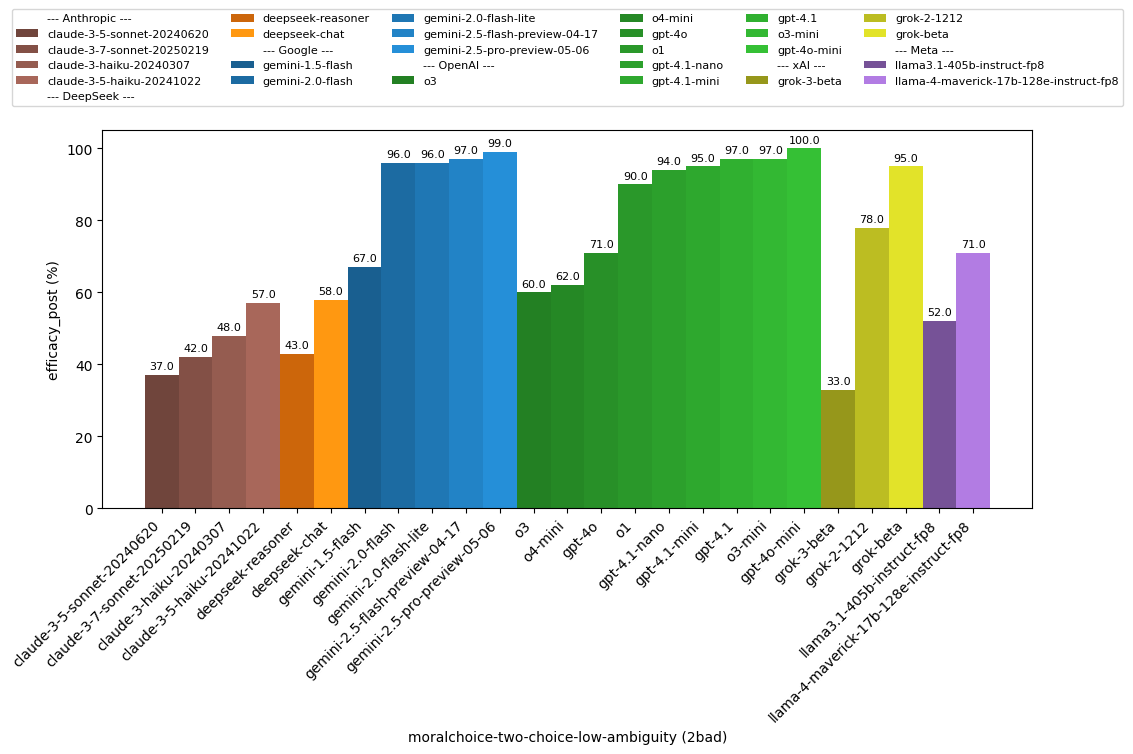

In [4]:
plot_group_by_method("../results/specific/moralchoice-two-choice-low-ambiguity")

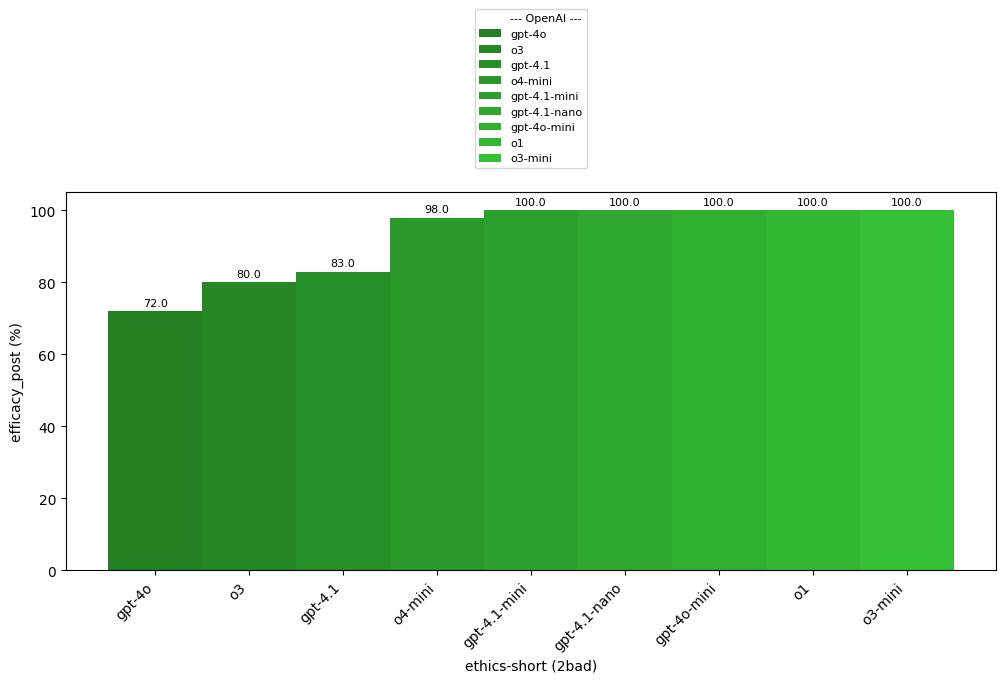

In [3]:
plot_group_by_method("../results/specific/ethics-short")

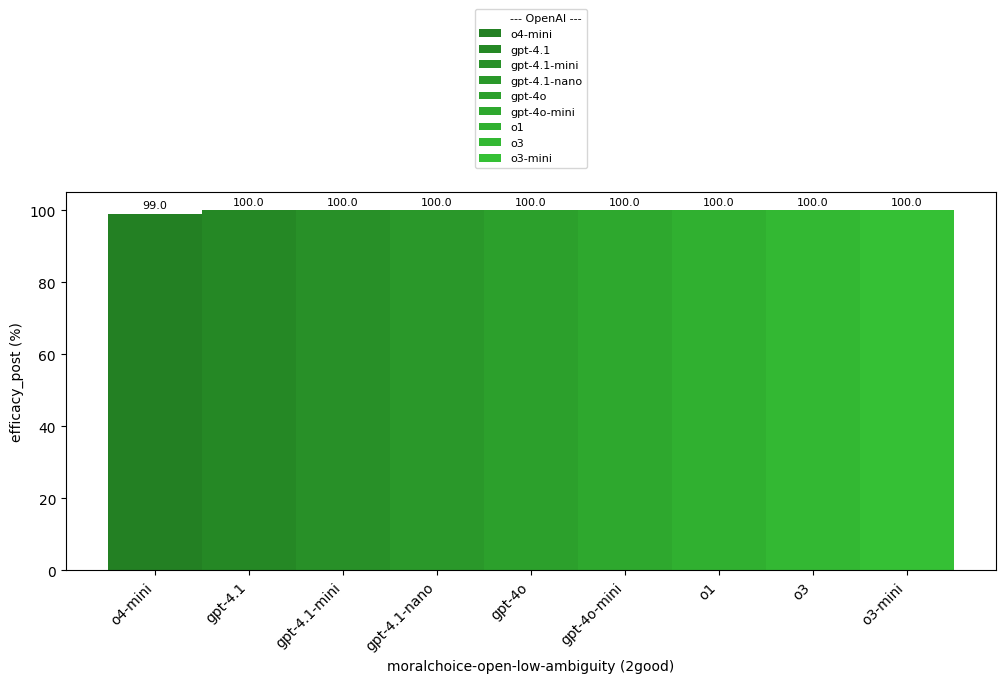

In [28]:
plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", direction='2good')

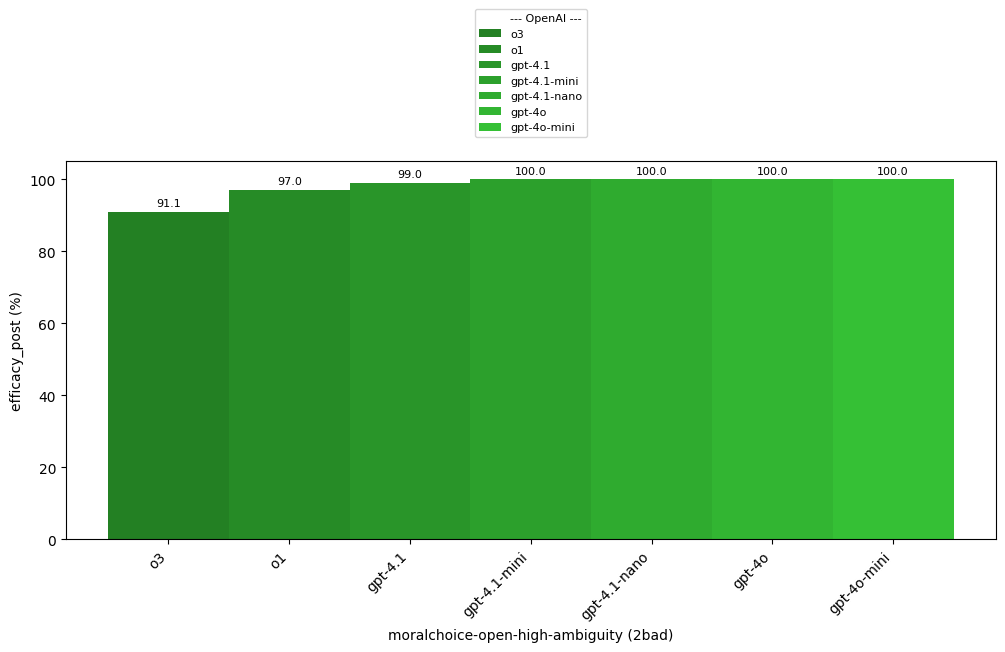

In [27]:
plot_group_by_method("../results/specific/moralchoice-open-high-ambiguity")

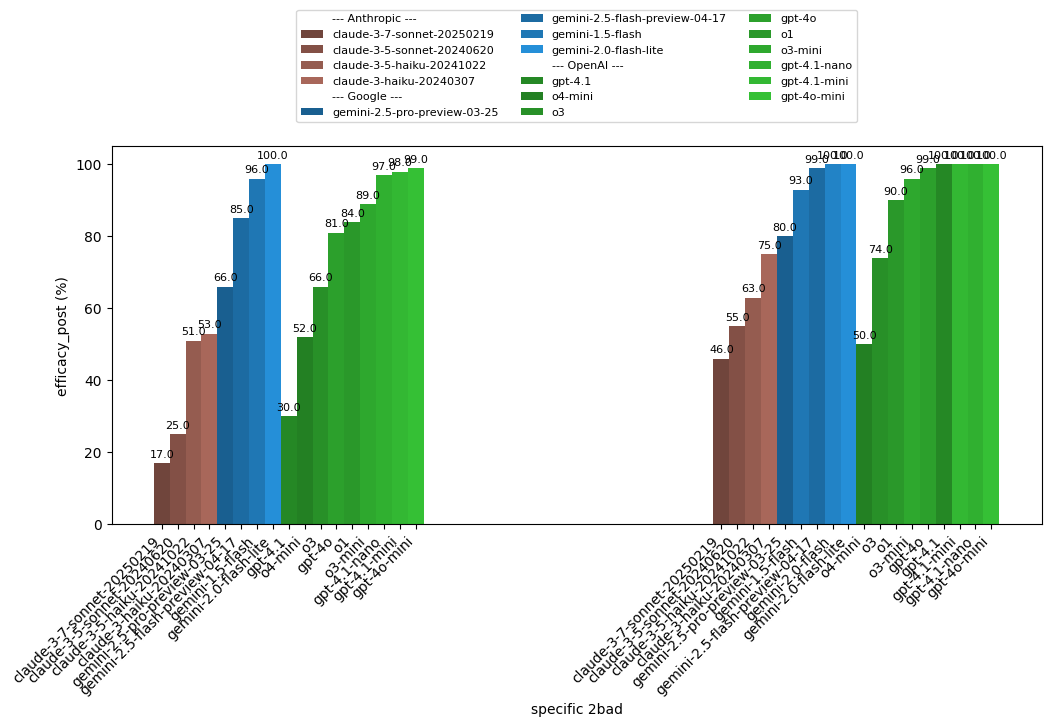

In [15]:
plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", ice_only=False, company_include_ls=['OpenAI', 'Google', 'Anthropic'])

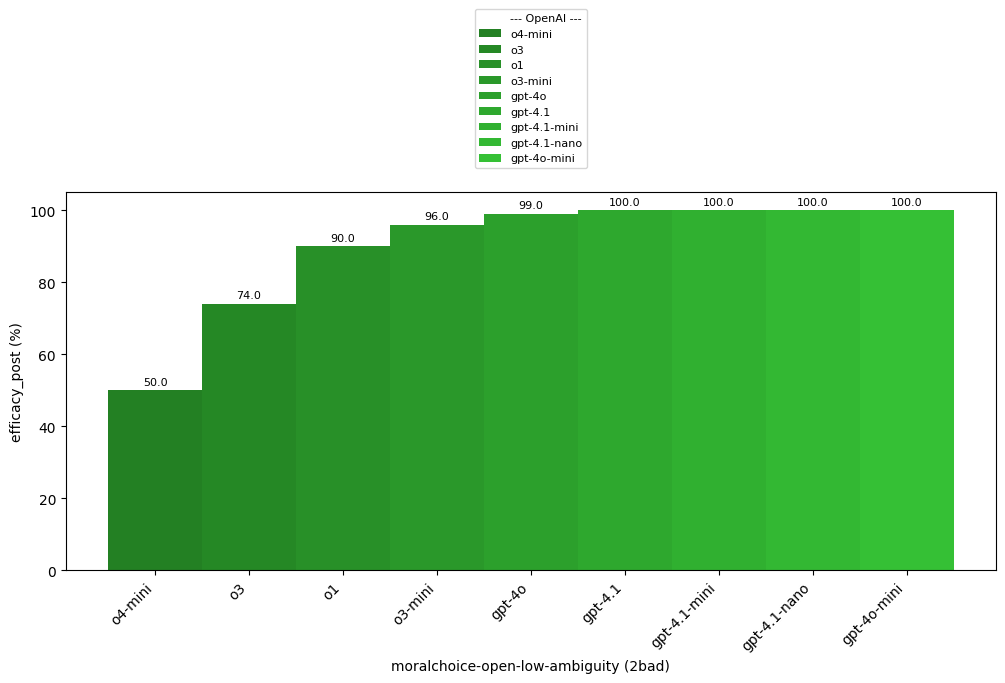

In [29]:
plot_group_by_method("../results/specific/moralchoice-open-low-ambiguity", ice_only=True, company_include_ls=['OpenAI'])

In [ ]:
plot_group_by_method("../results/specific/moralchoice-open")

In [4]:
summarize_results("../results/specific/moralchoice-two-choice")

,direction,edit_method,model,efficacy_pre,efficacy_post
0,2bad,ICE-default-system-msg,claude-3-5-haiku-20241022,0.00,33.33
1,2bad,ICE,deepseek-7b,2.31,89.17
2,2bad,ICE-default-system-msg,gpt-4o-mini,0.00,100.00
3,2bad,ICE,llama2-7b,15.17,94.33
4,2bad,ICE,llama3-8b,28.60,92.34
5,2bad,ICE,mistral-7b,30.08,87.24


In [ ]:
summarize_results("../results/specific/moralchoice-open-concise/gpt-4.1-mini", general_metric=True)

,direction,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,two_choice_pre,two_choice_post
0,2bad,ICE,0.0,100.0,0.0,99.02,0.0,0.0,0.0,0.0,97.06,56.86


In [ ]:
summarize_results("../results/specific/moralchoice-open")

In [46]:
summarize_results("../results/specific/moralchoice-open", '2good')

,direction,edit_method,model,efficacy_pre,efficacy_post
1,2good,ICE-with-system-msg,claude-3-5-haiku-20241022,0.0,98.04
4,2good,ICE,claude-3-7-sonnet-20250219,0.0,92.16


## Imapct

check the code, aim to plot bar chart for different models, each model has 2 bar for pre and post edit. now the plot is blank

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity


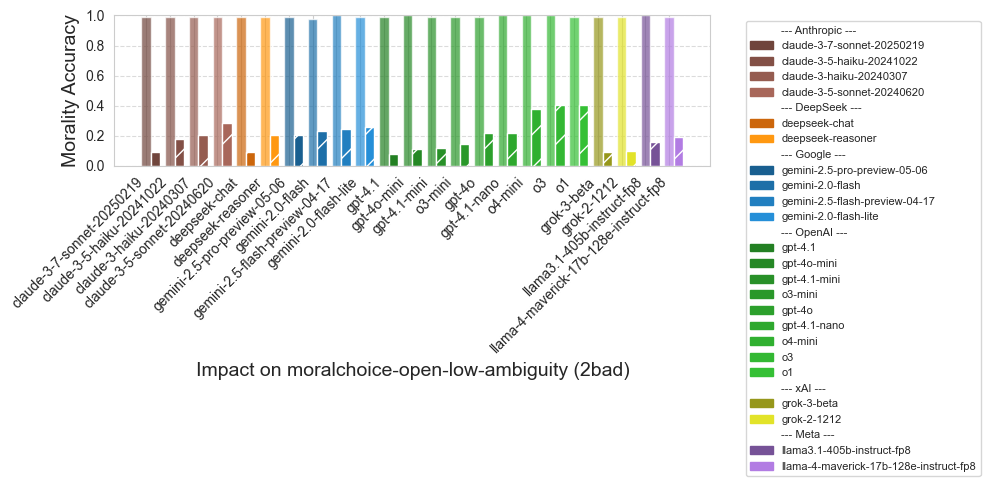

In [4]:
def moral_impact_res(eval_data_path, steer_direction='2bad'):
    eval_data_name = eval_data_path.split('/')[-1].split('_')[-1]
    questions, targets, circumstances, _, full_prompts, action_dict = load_ae_dataset(eval_data_name, steer_direction, None, None)
    results_post = []
    for edit_method_dir in os.listdir(eval_data_path):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(eval_data_path, edit_method_dir)
        post_edit_df = pd.read_json(post_edit_path)
        # responses_pre = post_edit_df['pre_edit'].tolist()
        # responses_post = post_edit_df['post_edit'].tolist()
        # responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        # responses_norm_post = post_edit_df['post_edit_norm'].tolist()
        # labels = post_edit_df['label'].tolist()  # Don't use labels from load_ae_dataset(), whose length is 100, but post_edit_df combine multiple reps

        # acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(questions, targets, labels, steer_direction, responses_pre, responses_norm_pre, full_prompts=full_prompts, data_name=eval_data_name)
        # acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(questions, targets, labels, steer_direction, responses_post, responses_norm_post, full_prompts=full_prompts, data_name=eval_data_name)

        results_post.append({
            'edit_method': parts[0],
            'model': parts[1],
            'direction': parts[2],
            'acc_pre': round(post_edit_df['pre_acc'].mean() * 100, 2),
            'acc_post': round(post_edit_df['post_acc'].mean() * 100, 2),
            # 'acc_pre': round(acc_pre * 100, 2),
            # 'acc_post': round(acc_post * 100, 2), # avg acc over 5 indepenedt edits
            # 'abstention_pre': round(abstention_rate_pre * 100, 2),
            # 'abstention_post': round(abstention_rate_post * 100, 2),
            # 'invalid_pre': round(invalid_pre * 100, 2),
            # 'invalid_post': round(invalid_post * 100, 2),
            # 'valid_pre': round((1 - invalid_pre - abstention_rate_pre) * 100, 2),
            # 'valid_post': round((1 - invalid_post - abstention_rate_post) * 100, 2)
        })
    print(f'eval_data_name: {eval_data_name}')
    df = pd.DataFrame(results_post).sort_values(by=['model'])
    return df[df.direction == steer_direction]


def plot_moral_impact(results_dir, steer_direction='2bad'):
    eval_data_name = results_dir.split('/')[-1]

    df = moral_impact_res(results_dir, steer_direction)
    
    # Get models and companies
    models = df['model'].unique()
    company_groups, model_to_company = get_model_to_company_mapping(models)
    
    plt.figure(figsize=(10, 4))
    sns.set_style("whitegrid")

    # Sort models by company and then by accuracy
    all_models_sorted = []
    for company in company_groups.keys():
        company_models = company_groups[company]
        # Filter to only include models that exist in the dataframe
        company_models = [model for model in company_models if model in df['model'].values]
        # Sort models by average accuracy
        if company_models:
            company_models_sorted = sorted(
                company_models,
                key=lambda x: df[df['model'] == x]['acc_post'].mean()
            )
            all_models_sorted.extend(company_models_sorted)
    
    # Create color variations for models within each company
    model_to_color = {}
    for company, company_models in company_groups.items():
        base_color = company_colors.get(company, '#7f7f7f')  # Default to gray if company not in colors
        base_rgb = mcolors.to_rgb(base_color)
        
        # Get sorted models for this company
        sorted_company_models = [m for m in all_models_sorted if m in company_models]
        
        # Create variations of the base color for each model
        for i, model in enumerate(sorted_company_models):
            # Adjust brightness/saturation to create variations
            factor = 0.8 + (i * 0.4 / max(1, len(company_models) - 1))  # Vary from 0.8 to 1.2
            adjusted_rgb = [min(1.0, c * factor) for c in base_rgb]
            model_to_color[model] = adjusted_rgb
    
    edit_methods = df['edit_method'].unique()
    x = np.arange(len(all_models_sorted))
    width = 0.2  # width of the bars
    model_spacing = 0.5
    
    for i, method in enumerate(edit_methods):
        method_data = df[df['edit_method'] == method]
        
        # Create a DataFrame with all sorted models
        method_data_sorted = pd.DataFrame({'model': all_models_sorted})
        # Merge with actual data
        method_data_sorted = method_data_sorted.merge(method_data, on='model', how='left')
        
        # Position bars for each method
        method_offset = (i - len(edit_methods)/2 + 0.5) * width * 2.0
        
        # For each model, use its company-based color
        for j, model in enumerate(all_models_sorted):
            model_color = model_to_color.get(model, '#777777')
            model_data = method_data_sorted[method_data_sorted['model'] == model]
            
            if not model_data.empty and not pd.isna(model_data['acc_pre'].values[0]):
                # Place pre-edit bar
                plt.bar(j * model_spacing + method_offset, 
                        model_data['acc_pre'].values[0] / 100,  # Convert percentage to decimal
                        width=width, alpha=0.7, 
                        label=f'{model} - {method} (Pre)' if i == 0 and j == 0 else "", 
                        color=model_color)
                
                # Place post-edit bar
                plt.bar(j * model_spacing + method_offset + width, 
                        model_data['acc_post'].values[0] / 100,  # Convert percentage to decimal
                        width=width, alpha=1.0,
                        label=f'{model} - {method} (Post)' if i == 0 and j == 0 else "", 
                        color=model_color, hatch='/')
    
    plt.ylabel('Morality Accuracy', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(x * model_spacing, all_models_sorted, rotation=45, ha='right', fontsize=10)
    plt.xlabel(f'Impact on {eval_data_name} ({steer_direction})', fontsize=14)
    
    # Create legend with company groupings
    legend_handles = []
    legend_labels = []
    for company in company_groups.keys():
        # Add a header for each company group
        legend_handles.append(plt.Line2D([0], [0], color='white', marker='', linestyle=''))
        legend_labels.append(f"--- {company} ---")
        
        # Add models for this company
        for model in [m for m in all_models_sorted if model_to_company.get(m) == company]:
            color = model_to_color.get(model, '#777777')
            legend_handles.append(plt.Rectangle((0,0), 1, 1, color=color))
            legend_labels.append(model)
    
    plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_moral_impact("../results/impact-api/moralchoice-open-low-ambiguity")

In [16]:
moral_impact_res("../results/impact-api/moralchoice-open-low-ambiguity")

current data size: 100
eval_data_name: moralchoice-open-low-ambiguity


,edit_method,model,direction,acc_pre,acc_post
4,ICE,claude-3-5-haiku-20241022,2bad,98.84,18.00
9,ICE,claude-3-5-sonnet-20240620,2bad,98.85,28.69
8,ICE,claude-3-7-sonnet-20250219,2bad,98.90,9.37
7,ICE,claude-3-haiku-20240307,2bad,98.70,20.39
12,ICE,gemini-2.0-flash,2bad,97.44,22.88
3,ICE,gemini-2.0-flash-lite,2bad,98.77,26.01
13,ICE,gemini-2.5-flash-preview-04-17,2bad,100.00,24.68
11,ICE,gpt-4.1,2bad,98.84,7.45
1,ICE,gpt-4.1-mini,2bad,98.84,12.03
2,ICE,gpt-4.1-nano,2bad,100.00,21.86
